# Make data and load data explained

Global Forest Change dataset https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html is divided into 10x10 degree tiles, each of which comes with six raster files per tile: treecover, gain, data mask, loss year, first and last. All files contain unsigned 8-bit values and have a spatial resolution of 1 arc-second per pixel, which correspond to approximately 30 meters per pixel around the equator. After 2013 loss year and last files were updated annually. The last 2018 loss year file assign an integer value 0-18 to each pixel. 1-18 corresponds to the year (2001-2018) at which deforestation event was observed at this location or 0 if the deforestation was not detected there in the period 2001-2018. The dataset is such that once a pixel is assigned as deforestrated, it does not go back to forested at any time in the future. We collected the following ten tif files: treecover, gain, datamask, all "last" files from 2014 to 2018 and the most recent, 2018, loss year file. As our target area Madre de Dios is located at the intersection of three of the Hansen dataset tiles, for each of the ten files we collected the the corresponding tiles, merged them together in one raster file and cropped it with the Madre de Dios shape file. R file can be fond in r_code/R.ipynb. The resulting raster file was of spatial size 14646 x 15723 pixels and those pixels that were outside Madre de Dios boundaries were masked as NA values. Since we wish our models to be able to predict the label of each pixel of Madre de Dios area by analyzing an image, or time series of images, that captures its local region, we also included pixels lying in a buffer area of 0.09 degree (or approximately 10km) in our dataset. This allowed us to extract features from images that cover area up to 10km away from any Madre de Dios pixel.

<br> **from R:**
    
    Junin area corresponds to two tiles. 
    An R script has been run to collect this tiles, merge them, and mask them
    with Junin area + buffer shape file. See R notebook for more details.

    The following tiff files were then created and saved in sourcepath = '/home/ubuntu/Madre':
        
        datamask_2018.tif  
        gain_2018.tif
        treecover2000_2018.tif
        if_in_buffer.tif
        
        lossyear_2018.tif
        last_2018_1.tif
        last_2018_2.tif
        last_2018_3.tif
        last_2018_4.tif 
        
        last_2017_1.tif
        last_2017_2.tif
        last_2017_3.tif
        last_2017_4.tif
        
        last_2016_1.tif
        last_2016_2.tif
        last_2016_3.tif
        last_2016_4.tif
        
        last_2015_1.tif
        last_2015_2.tif
        last_2015_3.tif
        last_2015_4.tif
        
        last_2014_1.tif
        last_2014_2.tif
        last_2014_3.tif
        last_2014_4.tif

        Each file is one layer raster file of shape 14646, 15723. NA values are encoded as -1.
        NA values are pixels that were masked as they are not in the Madre de Dios area and its buffer   

**datamask_2018.tif**:
    
    is a layer that has values 0,1,2,or -1.
            0 for no data (Madre de Dios does not have pixels with no data)
            1 for mapped land surface
            2 for permanent woter bodies
            -1 for masked pixel

**gain_2018.tif**

        is a layer that has values 0,1,or -1.
            0 for no gain experienced between 2001 and 2012
            1 for gain experienced between 2001 and 2012
            -1. for masked pixel
        
**treecover2000_2018.tif**

        is a layer that has values between 0,100,or -1.
            value between 0 and 100 indicates percentage three cover observed in 2000.
            -1 for masked pixel


**if_in_buffer.tif**

        is a layer that has values 0,1,or -1.
            0 if a pixel lies in Madre de Dios area
            1 if a pixel lies in the buffer area
            -1 for masked pixel
            
The first three files are produced form the files:
    datamask
    gain
    treecover2000
    
    Downladed from:
    https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html

For how if_in_buffer.tif was created see R notebook.    

  **lossyear_2018.tif**
    
    Downladed from:
    https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html
    contains the most recent lossyear file.
    
    layer with values 0,1,2,3,..18 or -1
        0 for no loss experienced between 2001 and 2018
        1,2,3..18 for loss experienced in 2001, 2002, 2003,..2018
        -1 for masked pixel
    
    
    last_2018_1.tif
    last_2018_2.tif
    last_2018_3.tif
    last_2018_4.tif
    
    The "last" file 4 bands corresponding to year 2018
    each has values between 0:255 or -1
        masked pixels have value -1

# Input layers:

<img src="images/table.png">

The only feature we constructed from Hansen data is one hot encoded cathegorical variable **if loss when** that for each neighbouring pixel encodes if it has experienced deforestation and how far in the past this was obsered. If pixel did not experienced deforestation, all cathegorical layers have 0 at that location. Our motivation to have it is because we had the hypothesis that deforestation event cluster in certain areas. Therefore, we wanted to have feature that summarize the information of neighbouring pixels' deforestation state. 

One can set different enocding through function:

    def if_def_when(lossyear,year,cutoffs = [2,5,8]):
        """
        Creates categorical variables for deforestration event given cutoffs.
        Values in cutoffs define the time bins
        Returns len(cutoffs) + 1 cathegorical layers:
        Example: cutoffs = [2,5,8], num of layers = 4 , considered year = year
        Cathegories 0,1,2,3 take values 1: 
        for layer 0 : if year - lossyear is in [0,2) 
        for layer 1 : if year - lossyear is in [2,5) 
        for layer 2 : if year - lossyear is in [5,8) 
        for layer 3 : if deforestation 8 years ago or more
        For a given considered year we have no prior knowledge for future deforestations:
            if loss event is in year > considered year or pixel is non deforested up to 2018+, 
            all categories have value 0 
        """

<br>Currently the cut offs are as follows:
        <br> For considered year t and loss taking values 1,2,3,4,...18:
        <br> if loss > t all cathegorical levels take 0. Otherwise: 
        <br>Layer 1) deforestation in the same or last year  = 1 if t - loss in [0,1] 
        <br>Layer 2) deforestation in the past 2 to 4  years = 1 if t - loss in [2,4] 
        <br>Layer 3) deforestation in the past 5 to 7  years = 1 if t - loss in [5,7] 
        <br>Layer 4) deforestation more than 7 years         = 1 if t - loss in [8,t-1] 

All our models were build so that they can take two or more tensors with the same spatial dimensions, which we define below, and forecast if deforestation is observed in the following year at the locating corresponding to the spatially-central pixel of these tensors.

The first 3D tensor that any of our models receives, which we named **static**, is tensor of shape $\mathbf{S} \in \mathbb{R}^{2 \times (2r+1) \times (2r+1)}$ where $(2r+1 \times 2r+1)$ is its spatial dimension and $r$ is a predefined hyperparameter that defines the number of pixels the input tensor to have in each spatial direction from the target central pixel. In the data classes implementation the parameter **size** correspond to **r**. The two chnnels of this tensor are treecover2000 and datamask. 

Our second set of tensors is a time series of 3D tensors $\mathbf{X}_{t-3}$,$\mathbf{X}_{t-2}$,$\mathbf{X}_{t}$ $\in \mathbf{R}^{d \times (2r+1) \times (2r+1)}$, where again each tensor has spatial dimensions $(2r+1) \times (2r+1)$ but depth **d = 4 + the number of layers of the if_loss_when** encoded variable. The channels of a tensor with time index $t$ are **if_loss_when(i,t), last_b30(t), last_b40(t), last_b50(t) and last_b70(t)** 

This time series is stored in 4D tensor of shape (c x t x 2r+1 x 2r+1) and here c = 4+4  and t = 3

Finally each tensor with time index $t$ comes with a label $Y_{t+1} \in \{0,1\}$ which takes value 1 only if the target central pixel (at spatial location $r+1 \times r+1$) is marked as deforested exactly in year $t+1$. To clarify this, here we note that if this pixel was labeled as deforested in any other year $t_j \neq t+1$ ,lossyear($t_j$) = 1, or was never labeled as deforested in the study period 2001-2018 , lossyear($t_j$) = 0 $\forall$ $t_j$ in ${1,2,..18}$, then $Y_{t+1} = 0$

## Set of valid pixels in each year

Due to the characteristics of Hansen dataset, we know that if a pixel is labeled as deforested in year $t_{j}$ then the pixel never returns to the state of being forested. Additionally, if its the percentage of tree cover observed in 2000 was below 30\%, than this location is not considered as forest. Only if a pixel with treecover2000<30% experience "gain" in the study period 2001-2012 we may assume it corresponds to a forested area from 2013 onward. Finally, if it has $datamask=1$ then we know it is a permanent water body. Having stated this facts, we note that if our models aim to forecast the label of a pixel with index $j$ , $Y^{j}_{t+1}  \equiv \mathbb{I}\{lossyear_j = t+1\}$, they would not be of any use if we know that this pixel j is not a forested area in year t. It will never be reverted to forest and therefore detecting deforestation at this location in year $t+1$ doesn't make sense. Therefore, when predicting the labels of pixels $Y{^j}_{t+1}$ in year $t+1$, we restricted these set of pixels to be:

$$\mathbf{J}_t =: \{j \in \mathbb{M} : ( lossyear_j > t \,\ \cup \,\ lossyear_j = 0 )$$ 
$$\cap (datamask_j = 1) \cap (treecover_j > 30\% \,\ \cup \,\ gain_j = 1) \}$$
where $\mathbb{M}$ is the index set of pixels lyng within Madre de Dios baundries. 

Since channel **treecover2000** has range 0:100 we rescaled it to be in the range 0:1.
<br>Each of the bands of Landset image composite is also separately normalized, where normalization is taken with respect to the spatial domain at a single time image. Reason for that is that different channels have different means and std. Mean and std are also computed per year because images might be taken at different seasons and therefore the channels values distribution might be different.
<br>Since for Madre de Dios datamask has no entrie = 0, we changed the valus as 0 - land, 1 - water bodies.

<br>For our last 3 models that utilize a time series of tensors we worked with the following dataset: $[\mathbf{S^j},\textbf{X}^j_{2014},\textbf{X}^j_{2015},\textbf{X}^j
_{2016}]$ as set of input tensors and $Y^j_{2017}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2016}$. 

<br>We split the data into train and validation data sets with ratio 8:2. From the 80% trainig data, a 5 fold cross validation training with early stopping was used. We used the validation data to select the best model of each class. We evaluated their performance on $[\mathbf{S^j},\textbf{X}^j_{2015},\textbf{X}^j_{2016},\textbf{X}^j_{2017}]$ as the set of input tensors and $Y^j_{2018}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2017}$.

<br>Our Model 1, 2D CNN model, is able to analyze only mono-temporal tensors and from them to extract features forecasting the central pixel deforestation label in the following year. We used the union of the following data pairs of tensors and labels as dataset:
<br>$[\mathbf{S^j},\textbf{X}^j_{2014}]$ as an input tensors and $Y^j_{2015}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2014}$.
<br>$[\mathbf{S^j},\textbf{X}^j_{2015}]$ as an input tensors and $Y^j_{2016}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2015}$.
<br>$[\mathbf{S^j},\textbf{X}^j_{2016}]$ as an input tensors and $Y^j_{2017}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2016}$.
<br>We evaluated its performance on :
<br>$[\mathbf{S^j},\textbf{X}^j_{2017}]$ as an input tensors and $Y^j_{2018}$ as the set of labels to be predicted where $j \in \mathbf{J}_{2017}$. 

<br> **WHERE IS THIS SAVED? PIXEL FILE?**


## The rest of this notebook explains how to use the tiff files to produce the above defined datasets.

Load needed packages.

sourcepath is the path to folder that has all tiff files.

wherepath is the path to folder where the tensors to be saved and loaded later

In [1]:
import torch
from torchvision.transforms import ToTensor
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from torch.utils.data import Dataset
import os.path
import numpy as np
#sourcepath is path to folder that has all tiff files.
# they must have value 111 for NA, and last tif file should come as last_year_1 for band 1 in year = year 
#wherepath is the path to folder where the tensors to be saved and laded later

# server = '/home/ubuntu/satellite' # for Amazon server
server = '/rds/general/project/aandedemand/live/satellite/junin'  # For Imperial HPC

sourcepath = '/data_reduced'
wherepath = '/data_reduced/tensors'

sourcepath = server + sourcepath
wherepath = server + wherepath
print(sourcepath, wherepath)

/rds/general/project/aandedemand/live/satellite/junin/data_reduced /rds/general/project/aandedemand/live/satellite/junin/data_reduced/tensors


In [2]:
#for visualising and time measurung
import matplotlib
import matplotlib.pyplot as plt
import time
print('done')

done


## **to_Tensor**
The following function open a raster (with one layer) as a tensor of size same as the tiff file - (14646, 15723)
<br>**path** is the sourcepath: '/home/ubuntu/Madre'
<br>**name** is one from above,  eg:  datamask_2018.tif,  gain_2018.tif,  treecover2000_2018.tif, if_in_buffer.tif

In [3]:
def to_Tensor(path,name):
    """
    Load Tiff files as tensors
    """
    t = Image.open(path+"/"+name)
    t = ToTensor()(t)
    t = t.squeeze(dim = 0)
    return(t)  

## datamask

<Figure size 1008x1008 with 0 Axes>

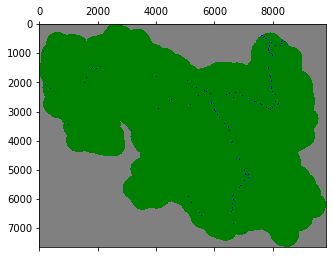

Number of pixels in AOI and buffer with no data (0 entries):  0


In [4]:
"""
datamask:
    -1 for NA value
    0 for no data pixel in Madre de Dios
    1 for land pixel in Madre de Dios
    2 for water body pixel in Madre de Dios 
"""
#Run this:
###############
datamask = to_Tensor(sourcepath,'Hansen/datamask_2018.tif')
##############

#visualise:
colors = ['grey','white','green','blue']
plt.fig = plt.figure(figsize=(14,14))
plt.matshow(datamask,cmap=matplotlib.colors.ListedColormap(colors))
plt.show()
print("Number of pixels in AOI and buffer with no data (0 entries): ", len((datamask == 0).nonzero()))

Since for AOI area all pixels have value $\neq 0$, to rescale this layer to be in range 0,1 we change encoding as follows:
     
     datamask:
    -1 for NA value
    0 for land pixel in AOI
    1 for water body pixel in AOI 

by running this line:

    datamask[datamask !=  -1] = datamask[datamask !=  -1] - 1 

In [5]:
datamask[datamask !=  -1] = datamask[datamask !=  -1] - 1 

## if_in_buffer

<Figure size 576x576 with 0 Axes>

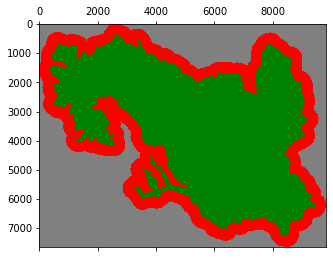

In [6]:
"""
Buffer:
    -1 for NA value
    0 for pixel in Madre de Dios
    1 for pixel in buffer
"""
buffer = to_Tensor(sourcepath,'buffer/if_in_buffer.tif')
#to visualise
colors = ['grey','green','red']
plt.fig = plt.figure(figsize=(8,8))
plt.matshow(buffer,cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

## DSM - new layer

Since no mask is applied, to mask the NA values with -1 do:

<Figure size 576x576 with 0 Axes>

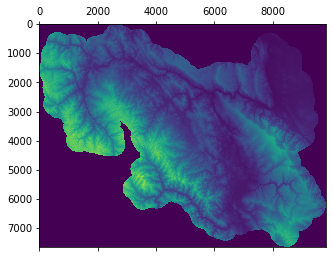

In [7]:
DSM = to_Tensor(sourcepath,'DSM/DSM_resample_clip_REDUCED.tif')
#DSM[datamask == -1 ] = -1
plt.fig = plt.figure(figsize=(8,8))
plt.matshow(DSM, norm = plt.Normalize(0, 6000))
plt.show()

Explore its values ditribution:

In [8]:
values = (DSM != -1).nonzero()
print(values)
values = DSM[ values[:,0] , values[:,1]].view(-1)
print(values)

tensor([[   0, 2651],
        [   0, 2652],
        [   0, 2653],
        ...,
        [7652, 8517],
        [7652, 8518],
        [7652, 8519]])
tensor([1371.2875, 1380.6450, 1386.6625,  ..., 3292.9475, 3301.5874,
        3313.1201])


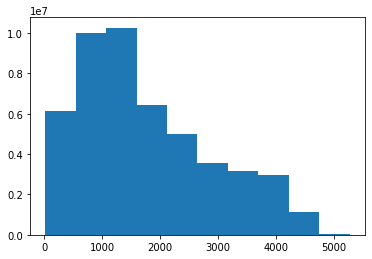

In [9]:
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

In [10]:
(values).min() 

tensor(16.5450)

Since values have positively skewed distribution take log transform. Since minimum value is 107, log transform without shift is possible.

In [11]:
DSM[DSM != -1] = np.log(DSM[DSM != -1])

After log transform:

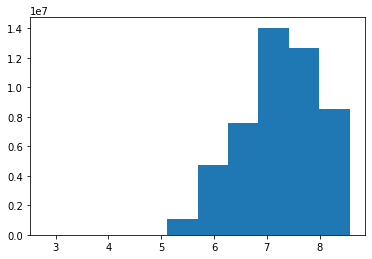

In [12]:
values = (DSM != -1).nonzero()
values = DSM[ values[:,0] , values[:,1]].view(-1)
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

To transform in order to have normal distribution:
<br> rescale_image function defined bellow

In [13]:
%cd ../
from Data_maker_loader import rescale_image
DSM  ,mean, std = rescale_image(DSM)
del rescale_image

/rdsgpfs/general/project/aandedemand/live/satellite/junin/deforestation_forecasting/python_code


In [14]:
print("Mean after log transform: ", mean)
print("Std after log transform: ", std)

Mean after log transform:  tensor([7.2419])
Std after log transform:  tensor([0.7253])


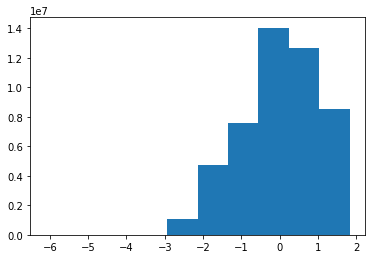

In [15]:
values = (DSM[:,:] != -1).nonzero()
values = DSM[ values[:,0] , values[:,1]].view(-1)
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

In [16]:
torch.save(DSM,wherepath+"/"+'DSM.pt')

### In summary, to include this layer do:

In [ ]:
DSM = to_Tensor(sourcepath,'DSM.tif')
# Mask area out of Madre de Dios and buffer
DSM[datamask == -1 ] = -1
# If positive skewed distribution of the values:
min_val  = DSM[DSM != -1 ].min().numpy()
print("Min value of the elevation: ",min_val)
# if there is negative values and zero values log transform must be applied after a shift to positive values only.
# log(0) = -Inf
if min_val > 0:
    DSM[DSM != -1] = np.log(DSM[DSM != -1])
else:
    DSM[DSM != -1] = np.log(DSM[DSM != -1] + min_val + 1)
#Normalise:
DSM, DSMmean, DSMstd = rescale_image(DSM)
print("Extracted mean: ",DSMmean)
print("Devided std: ",DSMstd)

## **last_to_image**

The following function open the 4 rasters (one for each band) of the last files (eg last_18_1,..last_18_4) and returns them as a tensors of size (4, 14646, 15723)

<br>**path** is the sourcepath
<br>**year** any of 13,14,15,16,17,18 

In [17]:
def last_to_image(path,year):
    """
    Given path to folder having tiff files for each last band for given year
    returns Tensors with chanels == bands and year as requested in the path
    """
    image = [] 
    for b in range(1,5):
        band = Image.open(path+"/"+'Hansen/last_20%d_%d.tif'%(year,b))
        band = ToTensor()(band)
        image.append(band)
    image = torch.cat(image,dim = 0)
    image = image.float()
    return(image)

In [22]:
start = time.time()
#Run this:###########
last_16 = last_to_image(sourcepath,16)
####################
print(last_16.shape)
print("Time needed to load one last file as tensor (in seconds): ",time.time() - start)

torch.Size([4, 17964, 16852])
Time needed to load one last file as tensor (in seconds):  41.979917764663696


## Rescale Image
<br> **rescale_image**

Get satelite image of Madre de Dios area at a given year, compute the mean and std of all
non-masked pixels (those covering Madre de Dios area) and returns a normalized satellite image.
Normalization is done per channel. Reason for that is that different channels have different means and 
std. Mean and std are also conputed per year because images might be taken at different seasons and therefore the channels values distribution might be different.

### Here we illustrate the 4 channels values distributions  of year 2016 satellite image 

In [24]:
pixels = (last_16[1,:,:] != -1).nonzero()
values1 = last_16[0, pixels[:,0] , pixels[:,1]].view(-1)
values2 = last_16[1, pixels[:,0] , pixels[:,1]].view(-1)
values3 = last_16[2, pixels[:,0] , pixels[:,1]].view(-1)
values4 = last_16[3, pixels[:,0] , pixels[:,1]].view(-1)

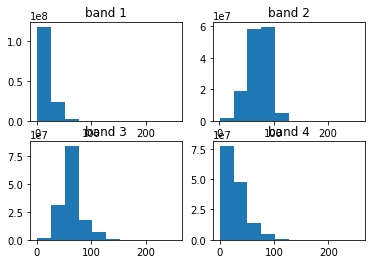

In [25]:
plt.fig = plt.figure()
plt.subplot(2, 2, 1)
plt.hist(values1.numpy())
plt.title("band 1")
plt.subplot(2, 2, 2)
plt.hist(values2.numpy())
plt.title("band 2")
plt.subplot(2, 2, 3)
plt.hist(values3.numpy())
plt.title("band 3")
plt.subplot(2, 2, 4)
plt.hist(values4.numpy())
plt.title("band 4")
plt.show()

In [18]:
def rescale_image(image):
    # detach and clone the image so that you don't modify the input, but are returning new tensor.
    rescaled_image = image.data.clone()
    if(len(image.shape) == 2):
        rescaled_image = rescaled_image.unsqueeze(dim = 0)
    # Compute mean and std only from non masked pixels
    # Spatial coordinates of this pixels are:
    pixels = (rescaled_image[0,:,:] != -1).nonzero()
    mean = rescaled_image[:, pixels[:,0] , pixels[:,1]].mean(1,keepdim=True)
    std = rescaled_image[:, pixels[:,0] , pixels[:,1]].std(1,keepdim=True)
    rescaled_image[:, pixels[:,0] , pixels[:,1]] -= mean
    rescaled_image[:, pixels[:,0] , pixels[:,1]] /= std
    if(len(image.shape) == 2):
        rescaled_image = rescaled_image.squeeze(dim = 0)
        mean = mean.squeeze(dim = 0)
        std = std.squeeze(dim = 0)
    return(rescaled_image,mean,std)

In [27]:
st = time.time()
rescaled_image, mean, std = rescale_image(last_16)
print("Time to rescale one year image:",time.time() - st)
print("\nMean of channles : \n",mean)
print("\nStd of channles : \n",std)
print("\nOriginal image preserved: ",last_16[:,555,7777])
print("Rescaled values at this location: ",rescaled_image[:,555,7777])

Time to rescale one year image: 18.758196115493774

Mean of channles : 
 tensor([[18.5237],
        [72.7132],
        [63.6026],
        [31.1686]])

Std of channles : 
 tensor([[13.4344],
        [19.2726],
        [19.4598],
        [16.9414]])

Original image preserved:  tensor([-1., -1., -1., -1.])
Rescaled values at this location:  tensor([-1., -1., -1., -1.])


#### Rescale_image can also be applied to any tensor of 2 dimensions. 
In this case rescaling is done with respect to the whole area in Made de Dios (that does not have -1 values) Note: if a new tensor has negative values by characteristics, one musth change the encoding.

## Create Categorical Layers Indicationg Deforestation Times Periods **if_def_when**

    Takes as input:
        
        the lossyear tensor; 
        the year to be considered as current t; t is one of 1,2,3,..18
        the cutoffs - list of cut of values (of lenght n) that determine the one hot encoding
        
    Returns:
        
        "One hot" encded 3D tensor with shpe ([n+1, 14646, 15723]) for loss event.
    
    Example: 
        
        Takes: 2D lossyear tensor, year = 14, cutoffs = [2,5,8] (n=3).
        Returns: 3D Cathegorical tensor with num of layers = 4 (n+1) 
    
    Each Cathegorical layer gets value 1 if: 
    
    for layer 0: if year - lossyear is in [0,2) i.e: 14-14, 14-13 (lossyear = 14 , 13)
    for layer 1: if year - lossyear is in [2,5) i.e: 14-12, 14-11, 14-10 (lossyear = 12 , 11, 10)
    for layer 2: if year - lossyear is in [5,8) i.e: 14-9, 14-8, 14-7 (lossyear = 9 , 8, 7)
    for layer 3: 8 years ago or more i.e: 14-6, 14-5,...14-1 (lossyear = 6, 5, 4, 3, 2, 1)

If lossyear value of a pixel is 0 or greater than t ( lossyear > 14 ), all cathegorical layers have value 0, which indicates that at year t=14, we know this pixel is not deforested yet. We consider all future deforestations event for year t = 14 as not observed yet ,"unknown". If pixel is masked, all cathegorical values take the NA value -1

In [19]:
def if_def_when(lossyear,year,cutoffs = [2,5,8]):
    """
    Creates categorical variables for deforestration event given cutoffs.
    Values in cutoffs define the time bins
    Returns len(cutoffs) + 1 cathegorical layers:
    Example: cutoffs = [2,5,8], num of layers = 4 , considered year = year
    Cathegories: 
    0) if year - lossyear is in [0,2) 
    1) if year - lossyear is in [2,5) 
    2) if year - lossyear is in [5,8) 
    3) 8 years ago or more
    No prior knowledge:
        if loss event is in year > considered year or pixel is non deforested up to 2018+, all cathegories have value 0 
    """
    cutoffs.append(year)
    cutoffs.insert(0,0)
    lossyear[ (lossyear > year) ] = 0
    losses = []
    for idx in range(0,len(cutoffs) - 1 ):   
        deff = torch.zeros(lossyear.size())
        deff[ (cutoffs[idx] <= (year - lossyear)) & ( (year - lossyear) < cutoffs[idx+1]) ] = 1
        losses.append(deff.float())    
    losses = torch.stack(losses)
    #Return Nan values encoded as needed:
    losses[:, (lossyear== -1)] = -1
    return(losses)

In [30]:
lossyear = torch.tensor([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,-1,0]])
print("loss year cases:")
print(lossyear)
currentyear = 14
print("\nCurrent year: t=", currentyear)
when = if_def_when(lossyear, currentyear, cutoffs = [2,5,8])
print("\nNo prior knowledge for future deforestration. Lossyear modified to: ")
print(lossyear)
print("\nCorresponding categorical layers")
for i in range(0, len(when)):
    print("\nTime bin category %d\n"%i,when[i])

loss year cases:
tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15],
        [16, 17, 18, -1,  0]])

Current year: t= 14

No prior knowledge for future deforestration. Lossyear modified to: 
tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10],
        [11, 12, 13, 14,  0],
        [ 0,  0,  0, -1,  0]])

Corresponding categorical layers

Time bin category 0
 tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  0.]])

Time bin category 1
 tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.]])

Time bin category 2
 tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.]])

Time bin category 3
 tensor([[ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],


# Create Tensors of Features to be used from models and save them for later usage. *create_tnsors_pixels*

Given year t, and cutoffs as defined above returns (and save them if wherepath!= None):
<br>Static tensor $S$,
<br>Non static tensor $X_t$,
<br>list of valid pixels coordinates $\mathbf{J}_{t}$
<br>list of labels corresponding to this valid cordinates: $Y^j_{t}$ where $j \in \mathbf{J}_{t}$
<br>Other two inputs are:
<br>sourcepath = path to tiff files
<br>wherepath = if not None, path to the folder where to save these tensors
        
<br>Static tensor is identical for any year, hence save only once. Static tensor has datamask layer and treecover
<br>Nonstatic tensor has if_deff_when cathegorical layers and the four bands of the landsat image stacked
    
    Valid pixels are these that meet all the following conditions :
     1. datamask == 1 , eg                        land not water body
     2. tree_cover > tree_p   or   gain == 1      if threecanpy in 2000 > tree_p or became forest up to 2012 
     3. lossyear > end_year   or   lossyear == 0  experienced loss only after that year (or not at all in the study period)    
     4. buffer == 0                               is in AOI area
     
$$\mathbf{J}_t =: \{j \in \mathbb{M} : ( lossyear_j > t \,\ \cup \,\ lossyear_j = 0 )$$ 
$$\cap (datamask_j = 1) \cap (treecover_j > 30\% \,\ \cup \,\ gain_j = 1) \}$$
Where $\mathbb{M}$ is the index set of pixels lyng within the ROI boundries. For each valid pixel j assign label $Y^j_{t} = 1$ if it is deforested in exactly in year = t+1 or zero otherwise.
<br>All pixels in the rasters and produced tensors have value -1 in the locations outside ROI area and its buffer

In [20]:
def create_tnsors_pixels(end_year, tree_p = 30, cutoffs = [2,5,8] , sourcepath = sourcepath ,rescale = True, wherepath = None):
    """
    Given year, and cutoffs as defined above returns (and save if wherepath!= None) 
        Static tensor,
        Non static tensor,
        list of valid pixels codrinates,
        list of labels corresponding to this valid cordinates
    
    sourcepath = path to tiff files
    wherepath = in not None, path to where to save the tensors
        
    Static tensor is identical for any year, hence save only once
    Static tensor has datamask layer and treecover
    
    Nonstatic tensor has if_deff_when cathegorical layers and the image landset 7 bands stacked
    
    Valid pixels are these that meet all the following conditions :
     1. datamask == 1 , eg                        land not water body
     2. tree_cover > tree_p   or   gain == 1      if tree canopy in 2000 > tree_p or became forest up to 2012 
     3. lossyear > end_year   or   lossyear == 0  experienced loss only after that year (or not at all in the study period)    
     4. buffer == 0                               is in Madre de Dios area
     
    for each valid pixel assign label 1 if it is deforested in exactly in year+1 or zero otherwise  
    
    All pixels in the rasters and produced tensors have value 111 in the locations outside Area of Interest and its buffer
    """
    buffer = to_Tensor(sourcepath,'buffer/if_in_buffer.tif')
    gain = to_Tensor(sourcepath,'Hansen/gain_2018.tif')
    lossyear = to_Tensor(sourcepath,'Hansen/lossyear_2018.tif')
    datamask = to_Tensor(sourcepath,'Hansen/datamask_2018.tif')
    tree_cover = to_Tensor(sourcepath,'Hansen/treecover2000_2018.tif')
    tree_cover = tree_cover.float()
    datamask = datamask.float()
    #Create list of valid pixels coordinates
    pixels = ( (datamask == 1) &                           #land (not water body)
               ((tree_cover > tree_p ) | (gain == 1)) &    #if forest in 2000 or became forest up to 2012 
               ((lossyear > end_year) | (lossyear == 0))&  #experienced loss only after that year (or not at all in the study period)    
               (buffer == 0)).nonzero()                    #In area of interest
    
    
    #Create list of valid pixels labels in year + 1
    labels = lossyear[pixels[:,0],pixels[:,1]] == (end_year+1)  #can be change to >= (end_year+1) & <111     

    when = if_def_when(lossyear,end_year, cutoffs = cutoffs)
    image = last_to_image(sourcepath,end_year)
    
    if rescale:
        #Rescale datamask to have values -1 for nan, 0 for land, 1 for water
        datamask[datamask !=  -1] = datamask[datamask !=  -1] - 1
        #Rescale tree_cover to have values in [0, 1] and -1 for nan
        tree_cover[tree_cover !=  -1] = tree_cover[tree_cover !=  -1]*0.01
        #Normalize image by channel with -1 values for nan
        image, _, _ = rescale_image(image)
        
    #Create non Static tensor
    image = torch.cat((when,image),dim=0)
    #Creates static tensor
    static = torch.stack((datamask,tree_cover))

    
    #Creates non static tensor
    if wherepath:
        if not os.path.isfile(wherepath+"/"+"static.pt"):
            torch.save(static, wherepath+"/"+"static.pt")
        torch.save(image, wherepath+"/"+"tensor_%d.pt"%(end_year))
        torch.save(pixels,wherepath+"/"+"pixels_cord_%d.pt"%(end_year))
        torch.save(labels,wherepath+"/"+"labels_%d.pt"%(end_year))

    return static, image, pixels, labels 
    

In [32]:
start = time.time()
static, image, pixels, labels = create_tnsors_pixels(18, tree_p = 30, cutoffs = [2,5,8] , sourcepath = sourcepath ,rescale = True, wherepath = None)
print("Total time (in seconds) needed to create tensors: ",time.time() - start)

Total time (in seconds) needed to create tenosrs:  147.33529424667358


In [33]:
torch.save(image, wherepath+"/"+"tensor_%d.pt"%(18))
torch.save(pixels,wherepath+"/"+"pixels_cord_%d.pt"%(18))

# Data Classes
In pytorch one need to have data class to load the data. This data class must have \__getitem\__(self, idx) function that returns the imput of the model and the output to which the prediction of the model is compared. Here \__getitem\__ returns the model input image/time series of images, the label of the central pixel and its cordinates. Each class must also have function that returns the dataset lenght: \__len\__(self)  

## CNN data class
As mentioned above, the data set for our CNN model is trained on all pairs of images labels for years 2014, 2015, 2016, 2017. To make this union of data pairs, the class is given lists. 

For example, to create CNN data class that has data points from Images in 2015 and 2016 and their corresponding labels in 2016 and 2017 respectively, image must be the list $\mathbf{X_{2015}}$, $\mathbf{X_{2016}}$, pixels must be the list of valid pixels coordinates in the corresponding year $\mathbf{J_{2015}}$, $\mathbf{J_{2016}}$, and labels must be $\mathbf{Y^{j_{2015}}_{2016}}$, $\mathbf{Y^{j_{2016}}_{2017}}$. The static tensor $\mathbf{S}$ is also gven to the data class.

The data set lenght is then the lenght of the set $\mathbf{J_{2015}} \cup \mathbf{J_{2016}}$ and when the function  \_getitem\_(self, idx) is given a index it returns the coresonding pixel static tensor $\mathbf{S}$ , image and label. The function idx_to_image(self,idx) maps each index to the correct pair of image,label with respect to wich year pair we refer to by this index.

The data class also have function change_size(self, new_size) that allows the spatial size of the tensor to be changed withouth re-initializing the class.

In [ ]:
class DatasetCNN(Dataset):
    """
    CNN Data class
        
        if it is passed list of image, pixels and labels, it concate the data as one, where inputs are
        all pairs of image:next year labels for valid pixels. Pairs are ordered as sequence in the same order as
        in the flatten list
        
        if list is of lenght 1, only one year pairs
        
        size is the radius of the image. Can be modified with Data.change_size(new size)   
    """

    def __init__(self, size, static, image, pixels, labels):       
        self.size = size
        self.lenghts = None
            
        if(len(image) == 1):
            image = torch.cat(image, dim = 0)
            self.image = torch.cat((static,image), dim = 0)
        
        else:
            #add static to each image in the list so that all images are ready tensors
            # do this only when initializig the data class so that it is quick to call ready tensor at each get item call
            #save tensors in a list keeping the image order
            
            #save the lengths of each item in the pixles codrintes/labels list 
            #so that after they are flattened, a map pixel,year -> image,year is possible
            self.lenghts = [ len(i) for i in pixels ]
            self.image = []
            for im in image:
                img = torch.cat((static,im), dim = 0)
                self.image.append(img)
              
        self.pixels = torch.cat(pixels, dim = 0)
        self.labels = torch.cat(labels, dim = 0)  
                
    def idx_to_image(self,idx):
        """
        given a index of a flatten list of pixels in different years,
        return the corresponding image for the given year
        """
        
        if self.lenghts == None:
            image = self.image
        
        else:
            csum = list(np.cumsum(self.lenghts))
            csum.insert(0,0)
            for i in range(1,len(csum)):
                if ((idx >= csum[i-1]) & (idx < csum[i])):              
                    image = self.image[i-1] 
                    break;
        return image
    
    def change_size(self, new_size):
        self.size = new_size
            
    def __getitem__(self, idx): 
        
        image = self.idx_to_image(idx)      
        image = image[:,
                        (self.pixels[idx,0] - self.size) : (self.pixels[idx,0] + self.size + 1),
                        (self.pixels[idx,1] - self.size) : (self.pixels[idx,1] +self.size + 1)] 
        
        label = self.labels[idx]
                      
        cor = self.pixels[idx]
                      
        return image , label, cor
    
    def __len__(self):
        return len(self.pixels)
    

## load_CNNdata 
This function takes as input the size one wish the CNNdata object to have and the start and end year of the pairs considered. It then loads the lists needed to initialize the data class and returns the corresponding CNNdata object.

If one wish to add extra static layers, than add_static must be a list of this tensors (2D or 3D for multi-channels)

If one wish to add extra time layers, than add_time must be a list of lists of this tensors (2D or 3D for multi-channels) where the lists are sorted in time and are of lenght end_year - start_year + 1

Eg:add_time = [[layer_1_2014, layer_2_2014],[layer_1_2015, layer_2_2015],[layer_1_2016, layer_2_2016]] where 
layer_1 and layer_2 can be 2D or 3D tensors.

In [ ]:
def load_CNNdata(size, start_year, end_year, add_static = None, add_time = None, path = wherepath):
    """
    given start year, end year and size initilalize CNN data class 
    start year and end year define how many pairs imange - next year label the data to have 
    size define the returned image size
    path = path to saved tensors
    """
    
    path = path + "/"
    static = torch.load(path+"static.pt")
    if(add_static):
        for to_add in add_static:
            if len(to_add.shape) == 2 :
                to_add = to_add.unsqueeze(dim = 0)
                static = torch.cat([static,to_add], dim = 0)
            else:
                static = torch.cat([static,to_add], dim = 0)      
    
    images_ls = []
    pixels_ls = []
    labels_ls = []
    
    for i, year in enumerate(range(start_year,end_year+1)):
        
        image = torch.load(path+"tensor_%d.pt"%(year))
        if(add_time):
            for to_add in add_time[i]:
                if len(to_add.shape) == 2 :
                    to_add = to_add.unsqueeze(dim = 0)
                    image = torch.cat([image,to_add], dim = 0)
                else:
                    image = torch.cat([image,to_add], dim = 0) 
        
        images_ls.append(image)
        
        pixels = torch.load(path+"pixels_cord_%d.pt"%(year))
        pixels_ls.append(pixels)
        
        labels = torch.load(path+"labels_%d.pt"%(year))
        labels_ls.append(labels)
        
    Data = DatasetCNN(size, static = static, image = images_ls, pixels = pixels_ls, labels = labels_ls)
    
    return Data

# DatasetRNN

This class is similar to the CNN class. To intialize it one needs to give it the size (= r) of the tensors, the static tensor, a 4D tensor coresponidng to the time series of images, organised as follows (channels,time,height,width), the set of valid pixels in the considered year and the coresponding next year labels for this set of pixels.

For example, to costruct the data set $\mathbf{S,X_{2014},X_{2015},X_{2016}}$ , $\mathbf{Y^{j_{2016}}_{2017}}$ , **static** must be $\mathbf{S}$, **image** bust be the 4D tensor, stack of $\mathbf{X_{2014},X_{2015},X_{2016}}$, **pixels** must be $\mathbf{J_{2016}}$ and **labels** must be $\mathbf{Y^{j_{2016}}_{2017}}$.

\__getitem\__(self, idx) returns the static image, the 4D tensor of time series of nonstatic images, the next year label and the coordinates of the pixel under that index.

In [ ]:
class DatasetRNN(Dataset):
    """
    Data class for Moldel 2:4
    get_item return static tensor (to be fed in the static branch)
    and a 4d Tensor of non static iamges where the shape is as follows: 
    (c,t,h,w) = (channels per image ,time , h = 2*size+1, w = 2*size+1)
    change_size sets new image size: h&w = 2*new_size + 1
    """

    def __init__(self, size, static, images, pixels, labels ):
        
        self.size = size
        self.static = static
        self.images = images        
        self.pixels = pixels
        self.labels = labels
        
    def change_size(self, new_size):
        self.size = new_size
                     
    def __getitem__(self, idx): 
                               
        static = self.static[:,
                              (self.pixels[idx,0] - self.size) : (self.pixels[idx,0] + self.size + 1),
                              (self.pixels[idx,1] - self.size) : (self.pixels[idx,1] +self.size + 1)]
                               #(c x t x h x w)
        images = self.images[:,:,
                                (self.pixels[idx,0] - self.size) : (self.pixels[idx,0] + self.size + 1),
                                (self.pixels[idx,1] - self.size) : (self.pixels[idx,1] +self.size + 1)] 
        label = self.labels[idx]
                      
        return (static, images) , label

    def __len__(self):
        return len(self.pixels)
    

**load_RNNdata**
<br>Function that takes size, start_year, end_year and returns DataRNN object corresponding to this time period and size

If one wish to add extra static layers, than add_static must be a list of this tensors (2D or 3D for multi-channels)

If one wish to add extra time layers, than add_time must be a list of lists of this tensors (2D or 3D for multi-channels) where the lists are sorted in time and are of lenght end_year - start_year + 1

Eg:add_time = [[layer_1_2014, layer_2_2014],[layer_1_2015, layer_2_2015],[layer_1_2016, layer_2_2016]] where layer_1 and layer_2 can be 2D or 3D tensors.

In [ ]:
def load_RNNdata(size, start_year, end_year, add_static = None, add_time = None, path = wherepath):
    """
    given start year, end year and size initilalize RNN data class 
    start year and end year define number of elements in the time series of imanges
    size define the returned image size
    path = path to saved tensors
    """
    path = path + "/"
    images = []
    for i, year in enumerate(range(start_year,end_year+1)):
        
        image = torch.load(path+"tensor_%d.pt"%(year))
               
        if(add_time):
            for to_add in add_time[i]:
                if len(to_add.shape) == 2 :
                    to_add = to_add.unsqueeze(dim = 0)
                    image = torch.cat([image,to_add], dim = 0)
                else:
                    image = torch.cat([image,to_add], dim = 0) 
        
        
        image = image.unsqueeze(dim = 1)
        images.append(image)
        
    images = torch.cat(images, dim = 1)
    
    static = torch.load(path+"static.pt")
    
    if(add_static):
        for to_add in add_static:
            if len(to_add.shape) == 2 :
                to_add = to_add.unsqueeze(dim = 0)
                static = torch.cat([static,to_add], dim = 0)
            else:
                static = torch.cat([static,to_add], dim = 0)    
    
    pixels = torch.load(path+"pixels_cord_%d.pt"%(end_year))
    labels = torch.load(path+"labels_%d.pt"%(end_year)) 
    Data = DatasetRNN(size = size , images = images ,static = static, pixels = pixels, labels = labels)
    return Data

# Load Data

## Load CNN data with two years pairs, 16 & 17
<br> Data_16_17 = load_CNNdata(4, start_year = 16, end_year = 17, path = wherepath)    initialize CNN data for two years, 16 & 17 with image size 9
<br> Data_16_17.change_size(2)    to change the image size from $2 \times 4+1 = 9$ to $2 \times 2+1 = 5$

In [ ]:
Data_16_17 = load_CNNdata(4, start_year = 16, end_year = 17, path = wherepath)
print("Data lenght of 2 years:",len(Data_16_17))
loss = (Data_16_17.labels == 1).nonzero()
print("% deforested valid pixels in 2017 and 2018:")
print(len(loss)/len(Data_16_17.labels))
print("\nFirst band of statelite image layer: \n")
print(Data_16_17[8498][0][-4,:,:])
print("\nChnage size from 9 to 5:\n")
Data_16_17.change_size(2)
print("\n")
print(Data_16_17[8498][0][-4,:,:])
del Data_16_17

## Load 1 year data CNN
Data_17 = load_CNNdata(4, start_year = 17, end_year = 17, path = wherepath)

In [ ]:
Data_17 = load_CNNdata(4, start_year = 17, end_year = 17, path = wherepath)
print("% valid pixels deforested in 2018: ",len((Data_17.labels == 1).nonzero())/len(Data_17))
print("\nFirst band of statelite image layer: \n")
print(Data_17[55555][0][-4,:,:])
print("\nChnage size from 9 to 5:\n")
Data_17.change_size(2)
print(Data_17[55555][0][-4,:,:])
del Data_17

# Add DSM static tensor after it being transformed and rescaled  

In [ ]:
DSM = torch.load(wherepath+"/DSM.pt")

In [ ]:
Data_17 = load_CNNdata(4, start_year = 17, end_year = 17, path = wherepath, add_static = [DSM])

### data with updated layers:

In [ ]:
Data_17[99][0].shape

# Load RNN data:
RNNData = load_RNNdata(size = 2 , start_year = 14 , end_year = 17)

In [ ]:
RNNData = load_RNNdata(size = 2 , start_year = 14 , end_year = 16)
print("shape of the statich tensor: (static chanels, h, w) = ",RNNData[22][0][0].shape) # static
print("shape of the non statich tensor: (static chanels, time, h, w) = ",RNNData[22][0][1].shape) # images
loss = (RNNData.labels == 1).nonzero()
print("% deforested valid pixels in 2017:")
print(len(loss)/len(RNNData.labels))
del(RNNData)

# Summary:
<br> 1) Save tensors with :

In [21]:
  for year in range(14,18):
    print(year)
    static, image, pixels,labels = create_tnsors_pixels(year, tree_p = 0.3,
                                                       cutoffs = [2,5,8],
                                                       sourcepath = sourcepath,
                                                       wherepath = wherepath)
    print("Files saved!")
    print("\n") 

14
Files saved!


15
Files saved!


16
Files saved!


17
Files saved!


18
Files saved!




2) Load data with:

CNNData_16_17 = load_CNNdata(4, start_year = 16, end_year = 17, path = wherepath)

CNNData_17 = load_CNNdata(4, start_year = 17, end_year = 17, path = wherepath)

RNNData = load_RNNdata(size = 4 , start_year = 14 , end_year = 16, path = wherepath)

To add extra static layer:
        
        server = '/rdsgpfs/general/user/kpp15/home/Hansen'
        wherepath = server + '/data/raster/tensors'

        %cd server+ '/deforestation_forecasting/python_code'
        from Data_maker_loader import *

        DSM = torch.load(wherepath+"/DSM.pt")

        CNNdata = load_CNNdata(size = 45, start_year = 16, end_year = 16, path = wherepath, add_static = [DSM])
    # or
        CNNdata = load_CNNdata(size = 45, start_year = 14, end_year = 16, path = wherepath, add_static = [DSM])
    # or
        RNNdata = load_RNNdata(size = 45, start_year = 14, end_year = 16, path = wherepath, add_static = [DSM])    

# Appendix

## idx - image map for CNN data with several {image,next_year_label} pairs.

<br>Pixels cordinates from different years and labels from different years are mixed, more specifically concated sequentially. Get the correct image for given index, and therefore pixel[index], label[index].
<br> Example: 4 years, year 1 have 3 pixels, year 2 - 6, year 3 - 1, year 4 - 5.
<br> Pixels and labels are concated and make in total 15 data points.
<br> Four different images correspond to indexes 0:3, 3:9, 9:9, 10:15
<br> Note 0:3 returns 0,1,2 and 0:15 returns 0,1,2,..14. Python indexing start from 0

In [ ]:
v = [[1,1,1],[1,1,1,1,1,1,],[1],[1,1,1,1,1]]
lenghts = [ len(i) for i in v ]
print("num of pixels in each year: ",lenghts)
csum = list(np.cumsum(lenghts))
print("Culminative sum of number of pixels in each year: ",csum)
csum.insert(0,0)

for idx in range(0,csum[-1]):
    for i in range(1,len(csum)):
        if ((idx >= csum[i-1]) & (idx < csum[i])):              
            print("idx : ",idx,"in tensor: ",i-1)
            break;